# Full Grid Evolution by Tensor Contraction
## Proposal is estimated by Tensor Contraction
### 2D EA (J, -J, 1/2)

In [4]:
import torch
import numpy as np
import numba as nb
from scipy.linalg import sqrtm

In [5]:
import math
import time
from tqdm.auto import trange

In [6]:
from collections import defaultdict
import copy
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import os

---------------------------------
### Full grid

In [7]:
def j_matrix_init():
    global j_matrix
    #np.random.seed(1288688)
    j_matrix = np.zeros((dims[0], dims[1], 4), dtype=np.int8)
    for i in range(dims[0]):
        for j in range(dims[1]):
            j_matrix[i][j] = (-1) ** np.random.binomial(1, 1/2, 4)
    for i in range(dims[0]):
        for j in range(dims[1]):
            j_matrix[i][j][3] = j_matrix[(i-1)%dims[0]][j][1]
            j_matrix[i][j][0] = j_matrix[i][(j-1)%dims[1]][2]

In [8]:
def j_pos_one_matrix_init():
    global j_matrix
    j_matrix = np.ones((dims[0], dims[1], 4), dtype=np.float64)

In [9]:
def j_neg_one_matrix_init():
    global j_matrix
    j_matrix = -1 * np.ones((dims[0], dims[1], 4), dtype=np.float64)    

In [10]:
def j_matrix_frust_init():
    global j_matrix
    j_matrix = np.ones((dims[0], dims[1], 4), dtype=np.int8)
    for i in range(dims[0]):
        for j in range(dims[1]):
            if j % 2 != 0:
                j_matrix[i][j][1] = -1
                j_matrix[i][j][3] = -1
    for i in range(dims[0]):
        for j in range(dims[1]):
            j_matrix[i][j][3] = j_matrix[(i-1)%dims[0]][j][1]
            j_matrix[i][j][0] = j_matrix[i][(j-1)%dims[1]][2]

In [11]:
def B_tensor_prepare(j_vec):
    B_list = []
    for jj in j_vec:
        if jj == 1:
            B_list.append(B_pos)
        else:
            B_list.append(B_neg)
    return B_list

In [12]:
def bdy_vector_prepare(grid, id_loc, pos_index):
    """
    Args:
        grid: (np.array)
        id_loc: (tuple)
        pos_index: (int) 
        
    Returns:
        bdy_vector: (np.array)
    """
    id_row, id_col = id_loc
    if grid[id_row][id_col] == 1:
        if j_matrix[id_row][id_col][pos_index] == 1:
            bdy_vector = spin_pos_up
        else:
            bdy_vector = spin_neg_up
    else:
        if j_matrix[id_row][id_col][pos_index] == 1:
            bdy_vector = spin_pos_down
        else:
            bdy_vector = spin_neg_down
    return bdy_vector

In [13]:
def parameters_init(dims_init, beta_init, h_init):
    global grid_1, grid_2, grid_1_new, grid_2_new, dims, beta, h
    #np.random.seed(314)
    #np.random.seed(181)
    #np.random.seed(0)
    dims = (nb.int64(dims_init[0]), nb.int64(dims_init[1]))
    beta, h = nb.float64(beta_init), nb.float64(h_init)
    grid_1 = np.reshape(np.random.choice([nb.int8(-1), nb.int8(1)], 
                                         size=dims_init[0]*dims_init[1]), dims_init)
    grid_2 = np.reshape(np.random.choice([nb.int8(-1), nb.int8(1)], 
                                         size=dims_init[0]*dims_init[1]), dims_init)
    grid_1_new = np.reshape(np.random.choice([nb.int8(-1), nb.int8(1)], 
                                              size=dims_init[0]*dims_init[1]), 
                            dims_init)
    grid_2_new = np.reshape(np.random.choice([nb.int8(-1), nb.int8(1)], 
                                              size=dims_init[0]*dims_init[1]), 
                            dims_init)

In [14]:
global grid_1, grid_2, grid_1_new, grid_2_new
global dims, beta, j_matrix, h

In [15]:
dims_init = (4, 4)
#dims_init = (8, 8)
#dims_init = (16, 16)
#dims_init = (32, 32)
#dims_init = (64, 64)
#beta_init, h_init = np.log(1 + np.sqrt(2)) / 2, 0
beta_init, h_init = 5, 0
parameters_init(dims_init, beta_init, h_init)

In [16]:
j_matrix_frust_init()
#j_matrix_init()
#j_neg_one_matrix_init()
#j_pos_one_matrix_init()

In [17]:
my_device = torch.device('cuda:5') if torch.cuda.is_available() else torch.device('cpu')

In [18]:
def node_tensor_create(my_device=my_device):
    B_pos = torch.tensor(sqrtm(np.array([[np.exp(beta),np.exp(-beta)], 
                                         [np.exp(-beta),np.exp(beta)]])), 
                         dtype=torch.complex128, device=my_device)
    B_neg = torch.tensor(sqrtm(np.array([[np.exp(-beta),np.exp(beta)], 
                                         [np.exp(beta),np.exp(-beta)]])), 
                         dtype=torch.complex128, device=my_device)
    spin_up = torch.tensor([1, 0], dtype=torch.complex128, device=my_device)
    spin_down = torch.tensor([0, 1], dtype=torch.complex128, device=my_device)
    spin_pos_up = torch.einsum("i, ij -> j", [spin_up, B_pos])
    spin_pos_down = torch.einsum("i, ij -> j", [spin_down, B_pos])
    spin_neg_up = torch.einsum("i, ij -> j", [spin_up, B_neg])
    spin_neg_down = torch.einsum("i, ij -> j", [spin_down, B_neg])
    return B_pos, B_neg, spin_pos_up, spin_pos_down, spin_neg_up, spin_neg_down

In [19]:
def copy_tensor_create(my_device=my_device):
    I_2_array = np.zeros((2, 2))
    I_3_array = np.zeros((2, 2, 2))
    I_4_array = np.zeros((2, 2, 2, 2))
    I_2_up_array = np.zeros((2, 2))
    I_2_down_array = np.zeros((2, 2))
    I_3_up_array = np.zeros((2, 2, 2))
    I_3_down_array = np.zeros((2, 2, 2))
    I_up_array = np.zeros((2, 2, 2, 2))
    I_down_array = np.zeros((2, 2, 2, 2))
    for i in range(2):
        if i == 0:
            I_2_array[i, i] = np.exp(beta * h)
            I_3_array[i, i, i] = np.exp(beta * h)
            I_4_array[i, i, i, i] = np.exp(beta * h)
        else:
            I_2_array[i, i] = np.exp(-beta * h)
            I_3_array[i, i, i] = np.exp(-beta * h)
            I_4_array[i, i, i, i] = np.exp(-beta * h)
    I_up_array[0][0][0][0] = np.exp(beta * h)
    I_down_array[1][1][1][1] = np.exp(-beta * h)
    I_3_up_array[0][0][0] = np.exp(beta * h)
    I_3_down_array[1][1][1] = np.exp(-beta * h)
    I_2_up_array[0][0] = np.exp(beta * h)
    I_2_down_array[1][1] = np.exp(-beta * h)
    I_1 = torch.tensor([np.exp(beta * h), np.exp(-beta * h)], dtype=torch.complex128, device=my_device)
    I_2 = torch.tensor(I_2_array, dtype=torch.complex128, device=my_device)
    I_3 = torch.tensor(I_3_array, dtype=torch.complex128, device=my_device)
    I_4 = torch.tensor(I_4_array, dtype=torch.complex128, device=my_device)
    I_up = torch.tensor(I_up_array, dtype=torch.complex128, device=my_device)
    I_down = torch.tensor(I_down_array, dtype=torch.complex128, device=my_device)
    I_3_up = torch.tensor(I_3_up_array, dtype=torch.complex128, device=my_device)
    I_3_down = torch.tensor(I_3_down_array, dtype=torch.complex128, device=my_device)
    I_2_up = torch.tensor(I_2_up_array, dtype=torch.complex128, device=my_device)
    I_2_down = torch.tensor(I_2_down_array, dtype=torch.complex128, device=my_device)
    return I_1, I_2, I_3, I_4, I_up, I_down, I_3_up, I_3_down, I_2_up, I_2_down

In [20]:
def row_tensor_mpo_create(row_id):
    row_tensor_mpo = []
    B_list_left, B_list_right = [], []
    j_vec_left = [j_matrix[row_id][0][1], j_matrix[row_id][0][2], j_matrix[row_id][0][3]]
    j_vec_right = [j_matrix[row_id][-1][0], j_matrix[row_id][-1][1], j_matrix[row_id][-1][3]]
    for jj in j_vec_left:
        if jj == 1:
            B_list_left.append(B_pos)
        else:
            B_list_left.append(B_neg)
    B_list_left.append(I_3)
    for jj in j_vec_right:
        if jj == 1:
            B_list_right.append(B_pos)
        else:
            B_list_right.append(B_neg)
    B_list_right.append(I_3)
    A_3_left = torch.einsum("ij, kl, mn, jln -> ikm", B_list_left)
    A_3_right = torch.einsum("ij, kl, mn, jln -> ikm", B_list_right)    
    A_3_left = A_3_left.view([1, 2, 2, 2]).contiguous()
    A_3_right = A_3_right.view([2, 2, 1, 2]).contiguous()
    row_tensor_mpo.append(A_3_left)
    for col_id in range(1, dims[1]-1):
        B_list = []
        j_vec = j_matrix[row_id][col_id]
        for jj in j_vec:
            if jj == 1:
                B_list.append(B_pos)
            else:
                B_list.append(B_neg)
        B_list.append(I_4)
        A_4_i = torch.einsum("ij, kl, mn, pq, jlnq -> ikmp", B_list)
        A_4_i = A_4_i / A_4_i.norm()
        row_tensor_mpo.append(A_4_i)
    row_tensor_mpo.append(A_3_right)
    return row_tensor_mpo

In [21]:
def up_row_tensor_mps_create():
    row_tensor_mps = []
    j_vec_left = [j_matrix[0][0][1], j_matrix[0][0][2]]
    j_vec_right = [j_matrix[0][-1][0], j_matrix[0][-1][1]]
    B_list_left = [B_pos if j_vec_left[0] == 1 else B_neg, B_pos if j_vec_left[1] == 1 else B_neg, I_2]
    B_list_right = [B_pos if j_vec_right[0] == 1 else B_neg, B_pos if j_vec_right[1] == 1 else B_neg, I_2]
    A_2_left = torch.einsum("ij, kl, jl -> ik", B_list_left)
    A_2_left /= A_2_left.norm()
    A_2_right = torch.einsum("ij, kl, jl -> ik", B_list_right)
    A_2_right /= A_2_right.norm()
    A_2_left = A_2_left.view((1, 2, 2, 1)).contiguous()
    A_2_right = A_2_right.view((2, 2, 1, 1)).contiguous()
    row_tensor_mps.append(A_2_left)
    for col_id in range(1, dims[1]-1):
        j_vec = j_matrix[0][col_id]
        B_list = []
        j_vec = [j_vec[0], j_vec[1], j_vec[2]]
        for jj in j_vec:
            if jj == 1:
                B_list.append(B_pos)
            else:
                B_list.append(B_neg)
        B_list.append(I_3)
        A_3_i = torch.einsum("ij, kl, mn, jln -> ikm", B_list)
        A_3_i = A_3_i / A_3_i.norm()
        A_3_i = A_3_i.view([2, 2, 2, 1])
        row_tensor_mps.append(A_3_i)
    row_tensor_mps.append(A_2_right)
    return row_tensor_mps

In [22]:
def down_row_tensor_mps_create():
    row_tensor_mps = []
    j_vec_left = [j_matrix[dims[0]-1][0][2], j_matrix[dims[1]-1][0][3]]
    j_vec_right = [j_matrix[dims[0]-1][-1][0], j_matrix[dims[1]-1][-1][3]]
    B_list_left = [B_pos if j_vec_left[0] == 1 else B_neg, B_pos if j_vec_left[1] == 1 else B_neg, I_2]
    B_list_right = [B_pos if j_vec_right[0] == 1 else B_neg, B_pos if j_vec_right[1] == 1 else B_neg, I_2]
    A_2_left = torch.einsum("ij, kl, jl -> ik", B_list_left)
    A_2_left /= A_2_left.norm()
    A_2_right = torch.einsum("ij, kl, jl -> ik", B_list_right)
    A_2_right /= A_2_right.norm()
    A_2_left = A_2_left.view((1, 1, 2, 2)).contiguous()
    A_2_right = A_2_right.view((2, 1, 1, 2)).contiguous()
    row_tensor_mps.append(A_2_left)
    for col_id in range(1, dims[1]-1):
        j_vec = j_matrix[dims[0]-1][col_id]
        B_list = []
        j_vec = [j_vec[0], j_vec[2], j_vec[3]]
        for jj in j_vec:
            if jj == 1:
                B_list.append(B_pos)
            else:
                B_list.append(B_neg)
        B_list.append(I_3)
        A_3_i = torch.einsum("ij, kl, mn, jln -> ikm", B_list)
        A_3_i = A_3_i / A_3_i.norm()
        A_3_i = A_3_i.view([2, 1, 2, 2])
        row_tensor_mps.append(A_3_i)
    row_tensor_mps.append(A_2_right)
    return row_tensor_mps

In [23]:
def tensor_mpo_create():
    tensor_mpo = []
    up_row_tensor_mps = up_row_tensor_mps_create()
    tensor_mpo.append(up_row_tensor_mps)
    for row_id in range(1, dims[0]-1):
        row_tensor_mpo_i = row_tensor_mpo_create(row_id)
        tensor_mpo.append(row_tensor_mpo_i)
    down_row_tensor_mps = down_row_tensor_mps_create()
    tensor_mpo.append(down_row_tensor_mps)
    return tensor_mpo

In [24]:
global I_1, I_2, I_3, I_4, I_up, I_down, I_3_up, I_3_down, I_2_up, I_2_down

In [25]:
global B_pos, B_neg, spin_pos_up, spin_pos_down, spin_neg_up, spin_neg_down

In [26]:
global tensor_mpo

In [27]:
def tensors_init(my_device=my_device):
    global I_1, I_2, I_3, I_4, I_up, I_down, I_3_up, I_3_down, I_2_up, I_2_down
    global B_pos, B_neg, spin_pos_up, spin_pos_down, spin_neg_up, spin_neg_down
    global tensor_mpo
    I_1, I_2, I_3, I_4, I_up, I_down, I_3_up, I_3_down, I_2_up, I_2_down = copy_tensor_create(my_device)
    B_pos, B_neg, spin_pos_up, spin_pos_down, spin_neg_up, spin_neg_down = node_tensor_create(my_device)
    tensor_mpo = tensor_mpo_create()

In [28]:
tensors_init()

In [57]:
def row_up_mpo_to_mps_create(mpo_base):
    row_up_mps = []
    for i in range(dims[1]):
        tensor_up_mps = torch.squeeze(mpo_base[i])
        row_up_mps.append(tensor_up_mps)
    return row_up_mps

In [29]:
def row_down_mps_create(grid, id_row):
    mpo_i = tensor_mpo[id_row]
    row_down_mps = []
    for i in range(dims[1]):
        tuple_down_bdy = (id_row+1, i)
        down_bdy_vector = bdy_vector_prepare(grid, tuple_down_bdy, 3)
        tensor_down_mps = torch.einsum("ijkl, j -> ikl", [mpo_i[i], down_bdy_vector])     
        tensor_down_mps = tensor_down_mps / tensor_down_mps.norm()
        tensor_down_mps = torch.squeeze(tensor_down_mps)
        row_down_mps.append(tensor_down_mps)                           
    return row_down_mps

In [30]:
def eat(mpo_up, mpo_down):
    return [torch.einsum("ijkl, abcj-> iabkcl", mpo_up[i], mpo_down[i]).contiguous().view(mpo_up[i].shape[0] * mpo_down[i].shape[0], 
                                                                                          mpo_down[i].shape[1], -1, mpo_up[i].shape[3]) 
            for i in range(len(mpo_up))]     

In [31]:
def eat_with_norm(mpo_up, mpo_down):
    mpo_list = []
    for i in range(len(mpo_up)):
        mpo_i = torch.einsum("ijkl, abcj-> iabkcl", mpo_up[i], mpo_down[i]).contiguous().view(mpo_up[i].shape[0] * mpo_down[i].shape[0], 
                                                                                              mpo_down[i].shape[1], -1, mpo_up[i].shape[3])
        mpo_i = mpo_i / mpo_i.norm()
        mpo_list.append(mpo_i)
    return mpo_list

In [32]:
def compress(mps, chi):
    """
    This function comes from Prof. Pan Zhang's github. 
    https://github.com/QuantumBFS/SSSS/blob/master/2_tensor_network/tensor_contraction_simple.ipynb
    Note: This function is extended to complex field.
    """
    residual = 0
    for i in range(len(mps)-1): # From left to right, sweep once doing qr decompositions
        mps_i = torch.permute(mps[i], (0, 1, 3, 2))
        Q, R = torch.qr(mps_i.contiguous().view(mps_i.shape[0]*mps_i.shape[1]*mps_i.shape[2], -1))
        mps_i = torch.permute(Q.contiguous().view(mps_i.shape[0], mps_i.shape[1], mps_i.shape[2], -1), (0, 1, 3, 2))
        mps[i] = mps_i.contiguous()
        mps[i+1] = torch.einsum("ij, jabc->iabc", [R, mps[i+1]])
    for i in range(len(mps) - 1, 0, -1): # From right to left, sweep onece using svd on the tensor merged from two consecutive tensors.
        mps_ij = torch.einsum("ijkl, kabc->ijlabc", mps[i-1], mps[i]).view(mps[i-1].shape[3]*mps[i-1].shape[0]*mps[i-1].shape[1], 
                                                                           mps[i].shape[1]*mps[i].shape[2]*mps[i].shape[3])
        [U, s, V]=torch.svd(mps_ij.contiguous())
        s = s.to(dtype=torch.complex128)
        mps[i] = torch.conj(V[:, :chi]).t().contiguous().view(-1, mps[i].shape[1], mps[i].shape[2], mps[i].shape[3])
        U_reshaped = (U[:, :chi]@torch.diag(s[:chi])).contiguous().view(mps[i-1].shape[0], mps[i-1].shape[1], mps[i-1].shape[3], -1)
        mps[i-1] = torch.permute(U_reshaped, (0, 1, 3, 2)).contiguous()        
        tnorm = mps[i-1].norm()
        mps[i-1] /= tnorm
        residual += math.log(tnorm)
    return residual, mps

In [33]:
def compress_without_trunc(mps):
    """
    This function comes from Prof. Pan Zhang's github. 
    https://github.com/QuantumBFS/SSSS/blob/master/2_tensor_network/tensor_contraction_simple.ipynb
    Note: This function is extended to complex field.
    """
    residual = 0
    for i in range(len(mps)-1): # From left to right, sweep once doing qr decompositions
        mps_i = torch.permute(mps[i], (0, 1, 3, 2))
        Q, R = torch.qr(mps_i.contiguous().view(mps_i.shape[0]*mps_i.shape[1]*mps_i.shape[2], -1))
        mps_i = torch.permute(Q.contiguous().view(mps_i.shape[0], mps_i.shape[1], mps_i.shape[2], -1), (0, 1, 3, 2))
        mps[i] = mps_i.contiguous()
        mps[i+1] = torch.einsum("ij, jabc->iabc", [R, mps[i+1]])
    return residual, mps    

In [34]:
def contract_up_to_down(bond_dim=20):
    stack_mpo = []
    mpo_orig = tensor_mpo[0]
    stack_mpo.append(mpo_orig)
    for i in range(1, dims[0]-1):
        row_tensor_mpo_i = tensor_mpo[i]
        mpo_orig = eat_with_norm(mpo_orig, row_tensor_mpo_i)
        #_, mpo_orig = compress(mpo_orig, bond_dim)
        #_, mpo_orig = compress_without_trunc(mpo_orig)
        stack_mpo.append(mpo_orig)
    return stack_mpo

In [35]:
def row_sampling(grid_new, grid_old, id_row, mps_base, row_down_mps_new, row_down_mps_old, prob_list, my_device=my_device):
    stack_contract_new, stack_contract_old = [], []
    tensor_start_new = torch.einsum("ij, lj -> il", [mps_base[-1], row_down_mps_new[-1]])
    tensor_start_old = torch.einsum("ij, lj -> il", [mps_base[-1], row_down_mps_old[-1]])
    tensor_start_new = tensor_start_new / tensor_start_new.norm()
    tensor_start_old = tensor_start_old / tensor_start_old.norm()
    stack_contract_new.append(tensor_start_new)
    stack_contract_old.append(tensor_start_old)
    for i in range(len(mps_base)-2, 0, -1):
        tensor_i_new = torch.einsum("ijk, lmj -> ilkm", [mps_base[i], row_down_mps_new[i]])
        tensor_i_new = tensor_i_new / tensor_i_new.norm()
        tensor_i_old = torch.einsum("ijk, lmj -> ilkm", [mps_base[i], row_down_mps_old[i]])
        tensor_i_old = tensor_i_old / tensor_i_old.norm()
        tensor_start_new = torch.einsum("ijkl, kl -> ij", [tensor_i_new, tensor_start_new])
        tensor_start_new = tensor_start_new / tensor_start_new.norm()
        tensor_start_old = torch.einsum("ijkl, kl -> ij", [tensor_i_old, tensor_start_old])
        tensor_start_old = tensor_start_old / tensor_start_old.norm()
        stack_contract_new.append(tensor_start_new)
        stack_contract_old.append(tensor_start_old)
    ### Samping the head of the row
    id_tensor = 0
    tuple_down_bdy = (id_row+1, 0)
    down_bdy_vector_new = bdy_vector_prepare(grid_new, tuple_down_bdy, 3)
    down_bdy_vector_old = bdy_vector_prepare(grid_old, tuple_down_bdy, 3)
    j_vector = j_matrix[id_row][0]
    _, B_down, B_right, B_up = B_tensor_prepare(j_vector)
    tensor_right_new = stack_contract_new.pop()
    tensor_right_old = stack_contract_old.pop()
    tensor_right_new = torch.einsum("ij, mj -> im ", [tensor_right_new, B_right])
    tensor_right_old = torch.einsum("ij, mj -> im ", [tensor_right_old, B_right])
    tensor_down_new = torch.einsum("ij, j -> i", [B_down, down_bdy_vector_new])
    tensor_down_old = torch.einsum("ij, j -> i", [B_down, down_bdy_vector_old])
    tensor_up = mps_base[id_tensor]
    tensor_up = torch.einsum("jk, jl -> lk", [tensor_up, B_up])
    ### tensor_up shape lk
    tensor_up_right_new = torch.einsum("ij, jm -> im", [tensor_up, tensor_right_new])
    tensor_up_right_old = torch.einsum("ij, jm -> im", [tensor_up, tensor_right_old])
    z_three_edge_new = torch.einsum("ij, k -> ijk", [tensor_up_right_new, tensor_down_new])
    z_three_edge_old = torch.einsum("ij, k -> ijk", [tensor_up_right_old, tensor_down_old])
    z_up_new = torch.einsum("ijk, ijk -> ", [z_three_edge_new, I_3_up])
    z_down_new = torch.einsum("ijk, ijk -> ", [z_three_edge_new, I_3_down])
    z_up_old = torch.einsum("ijk, ijk -> ", [z_three_edge_old, I_3_up])
    z_down_old = torch.einsum("ijk, ijk -> ", [z_three_edge_old, I_3_down])
    z_new = z_up_new + z_down_new
    z_old = z_up_old + z_down_old
    prob_up_real_new, prob_down_real_new = z_up_new.real / z_new.real, z_down_new.real / z_new.real
    prob_up_real_old, prob_down_real_old = z_up_old.real / z_old.real, z_down_old.real / z_old.real
    prob_new, site = (prob_up_real_new, prob_down_real_new), (id_row, 0)
    prob_old = (prob_up_real_old, prob_down_real_old)
    prob_tensor = (prob_new, prob_old)
    grid_new, spin_vector_new, spin_vector_old, prob_list = mh_prop_tensor(grid_new, grid_old, site, 
                                                                           prob_tensor, prob_list)     
    #print(z)
    #print(prob_up_real)
    tensor_up_new = torch.einsum("ij, i -> j", [tensor_up, spin_vector_new])
    tensor_up_old = torch.einsum("ij, i -> j", [tensor_up, spin_vector_old])
    tensor_up_new = tensor_up_new / tensor_up_new.norm()
    tensor_up_old = tensor_up_old / tensor_up_old.norm()
    id_tensor += 1
    tuple_right_bdy = (id_row, 0)
    ### Sampling the body of the row
    for i in range(1, dims[1]-1):
        j_vector = j_matrix[id_row][i]
        tuple_left_bdy = (id_row, i-1)
        tuple_down_bdy = (id_row+1, i)
        left_bdy_vector_new = bdy_vector_prepare(grid_new, tuple_left_bdy, 2)
        left_bdy_vector_old = bdy_vector_prepare(grid_old, tuple_left_bdy, 2)
        down_bdy_vector_new = bdy_vector_prepare(grid_new, tuple_down_bdy, 3)
        down_bdy_vector_old = bdy_vector_prepare(grid_old, tuple_down_bdy, 3)                                                
        B_left, B_down, B_right, B_up = B_tensor_prepare(j_vector)
        tensor_right_new = stack_contract_new.pop()
        tensor_right_old = stack_contract_old.pop()
        tensor_right_new = torch.einsum("ij, mj -> im", [tensor_right_new, B_right])
        tensor_right_old = torch.einsum("ij, mj -> im", [tensor_right_old, B_right])
        tensor_left_new = torch.einsum("ij, j -> i", [B_left, left_bdy_vector_new])
        tensor_left_old = torch.einsum("ij, j -> i", [B_left, left_bdy_vector_old])
        tensor_up_new = torch.einsum("i, ikl, km -> ml", [tensor_up_new, mps_base[id_tensor], B_up])
        tensor_up_old = torch.einsum("i, ikl, km -> ml", [tensor_up_old, mps_base[id_tensor], B_up])
        tensor_up_right_new = torch.einsum("ij, jl -> il", [tensor_up_new, tensor_right_new])
        tensor_up_right_old = torch.einsum("ij, jl -> il", [tensor_up_old, tensor_right_old])
        tensor_down_new = torch.einsum("ij, j -> i", [B_down, down_bdy_vector_new])
        tensor_down_old = torch.einsum("ij, j -> i", [B_down, down_bdy_vector_old])
        z_four_edge_new = torch.einsum("ij, k, l -> ijkl", [tensor_up_right_new, tensor_down_new, tensor_left_new])
        z_four_edge_old = torch.einsum("ij, k, l -> ijkl", [tensor_up_right_old, tensor_down_old, tensor_left_old])    
        z_up_new = torch.einsum("ijkl, ijkl -> ", [z_four_edge_new, I_up])
        z_down_new = torch.einsum("ijkl, ijkl -> ", [z_four_edge_new, I_down])
        z_up_old = torch.einsum("ijkl, ijkl -> ", [z_four_edge_old, I_up])
        z_down_old = torch.einsum("ijkl, ijkl -> ", [z_four_edge_old, I_down])
        z_new = z_up_new + z_down_new
        z_old = z_up_old + z_down_old
        prob_up_real_new, prob_down_real_new = z_up_new.real / z_new.real, z_down_new.real / z_new.real
        prob_up_real_old, prob_down_real_old = z_up_old.real / z_old.real, z_down_old.real / z_old.real
        prob_new, prob_old = (prob_up_real_new, prob_down_real_new), (prob_up_real_old, prob_down_real_old)
        site = (id_row, i)
        prob_tensor = (prob_new, prob_old)
        grid_new, spin_vector_new, spin_vector_old, prob_list = mh_prop_tensor(grid_new, grid_old, site, 
                                                                               prob_tensor, prob_list)     
        #print(z)
        #print(prob_up_real)
        #print(z_up/z)
        tensor_up_new = torch.einsum("ij, i -> j", [tensor_up_new, spin_vector_new])
        tensor_up_old = torch.einsum("ij, i -> j", [tensor_up_old, spin_vector_old])
        tensor_up_new = tensor_up_new / tensor_up_new.norm()
        tensor_up_old = tensor_up_old / tensor_up_old.norm()
        id_tensor += 1
    ### Sampling the end of the row
    j_vec = j_matrix[id_row][dims[1]-1]
    B_left, B_down, B_right, B_up = B_tensor_prepare(j_vec)
    tuple_left_bdy = (id_row, dims[1]-2)
    tuple_down_bdy = (id_row+1, dims[1]-1)
    left_bdy_vector_new = bdy_vector_prepare(grid_new, tuple_left_bdy, 2)
    left_bdy_vector_old = bdy_vector_prepare(grid_old, tuple_left_bdy, 2)
    down_bdy_vector_new = bdy_vector_prepare(grid_new, tuple_down_bdy, 3)
    down_bdy_vector_old = bdy_vector_prepare(grid_old, tuple_down_bdy, 3)
    tensor_down_new = torch.einsum("ij, j -> i", [B_down, down_bdy_vector_new])
    tensor_down_old = torch.einsum("ij, j -> i", [B_down, down_bdy_vector_old])
    tensor_left_new = torch.einsum("ij, j -> i", [B_left, left_bdy_vector_new])
    tensor_left_old = torch.einsum("ij, j -> i", [B_left, left_bdy_vector_old])
    tensor_up_new = torch.einsum("i, ij, jl -> l", [tensor_up_new, mps_base[id_tensor], B_up])
    tensor_up_old = torch.einsum("i, ij, jl -> l", [tensor_up_old, mps_base[id_tensor], B_up])
    z_three_edge_new = torch.einsum("i, j, k -> ijk", [tensor_up_new, tensor_down_new, tensor_left_new])
    z_three_edge_old = torch.einsum("i, j, k -> ijk", [tensor_up_old, tensor_down_old, tensor_left_old])
    z_up_new = torch.einsum("ijk, ijk -> ", [z_three_edge_new, I_3_up])
    z_down_new = torch.einsum("ijk, ijk -> ", [z_three_edge_new, I_3_down])
    z_new = z_up_new + z_down_new
    z_up_old = torch.einsum("ijk, ijk -> ", [z_three_edge_old, I_3_up])
    z_down_old = torch.einsum("ijk, ijk -> ", [z_three_edge_old, I_3_down])
    z_old = z_up_old + z_down_old
    prob_up_real_new, prob_down_real_new = z_up_new.real / z_new.real, z_down_new.real / z_new.real
    prob_up_real_old, prob_down_real_old = z_up_old.real / z_old.real, z_down_old.real / z_old.real
    prob_new, site = (prob_up_real_new, prob_down_real_new), (id_row, dims[1]-1)
    prob_old = (prob_up_real_old, prob_down_real_old)
    prob_tensor = (prob_new, prob_old)
    grid_new, _, _, prob_list = mh_prop_tensor(grid_new, grid_old, site, 
                                               prob_tensor, prob_list)    
    #print(z)
    #print(prob_up_real)
    #print(z_up/z)
    return grid_new, prob_list

In [36]:
def mh_prop_tensor(grid_new, grid_old, site, prob_tensor, prob_list, my_device=my_device):
    prob_tensor_new, prob_tensor_old = prob_tensor  
    prob_list_new, prob_list_old = prob_list
    prob_rand = np.random.random()
    if prob_rand < prob_tensor_new[0]:
        spin_vector_new = torch.tensor([1, 0], dtype=torch.complex128, device=my_device)
        spin_new = 1
        prob_list_new.append(prob_tensor_new[0])
    else:
        spin_vector_new = torch.tensor([0, 1], dtype=torch.complex128, device=my_device)
        spin_new = -1
        prob_list_new.append(prob_tensor_new[1])
    grid_new[site[0]][site[1]] = spin_new
    if grid_old[site[0]][site[1]] == 1:
        spin_vector_old = torch.tensor([1, 0], dtype=torch.complex128, device=my_device)
        prob_list_old.append(prob_tensor_old[0])
    else:
        spin_vector_old = torch.tensor([0, 1], dtype=torch.complex128, device=my_device)
        prob_list_old.append(prob_tensor_old[1])        
    prob_list = (prob_list_new, prob_list_old)
    return grid_new, spin_vector_new, spin_vector_old, prob_list

In [37]:
def down_row_sampling(grid_new, grid_old, mpo_base, prob_list, my_device=my_device):
    id_row = dims[0] - 1
    stack_contract = []
    tensor_start = torch.einsum("ijkl, mlnj -> imkn", [mpo_base[-1], tensor_mpo[-1][-1]])
    tensor_start = torch.squeeze(tensor_start)
    tensor_start = tensor_start / tensor_start.norm()
    #print(tensor_start.shape)
    ### tensor_start shape il
    stack_contract.append(tensor_start)
    for i in range(dims[1]-2, 0, -1):
        tensor_i = torch.einsum("ijkl, mlnj -> imkn", [mpo_base[i], tensor_mpo[-1][i]])
        tensor_i = torch.squeeze(tensor_i)
        tensor_i = tensor_i / tensor_i.norm()
        tensor_start = torch.einsum("ijkl, kl -> ij", [tensor_i, tensor_start])
        tensor_start = tensor_start / tensor_start.norm()
        stack_contract.append(tensor_start)
    ### Samping the head of the row
    id_tensor = 0
    j_vector = j_matrix[id_row][id_tensor]
    B_left, B_down, B_right, B_up = B_tensor_prepare(j_vector)
    stack_contract.pop()
    tensor_up = mpo_base[id_tensor]
    tensor_up = torch.einsum("ijkl, jm -> imkl", [tensor_up, B_up])
    tensor_up = torch.squeeze(tensor_up)
    ### tensor_up shape lk
    #print(z)
    #print(prob_up_real)
    prob_new, prob_old, site = (1/2, 1/2), (1/2, 1/2), (id_row, 0)
    prob_tensor = (prob_new, prob_old)
    grid_new, spin_vector_new, spin_vector_old, prob_list = mh_prop_tensor(grid_new, grid_old, site, 
                                                                           prob_tensor, prob_list)    
    tensor_up_new = torch.einsum("ij, i -> j", [tensor_up, spin_vector_new])
    tensor_up_old = torch.einsum("ij, i -> j", [tensor_up, spin_vector_old])    
    tensor_up_new = tensor_up_new / tensor_up_new.norm()
    tensor_up_old = tensor_up_old / tensor_up_old.norm()
    id_tensor += 1
    ### Sampling the body of the row
    for i in range(1, dims[1]-1):
        j_vector = j_matrix[id_row][i]
        tuple_left_bdy = (id_row, i-1)
        left_bdy_vector_new = bdy_vector_prepare(grid_new, tuple_left_bdy, 2)
        left_bdy_vector_old = bdy_vector_prepare(grid_old, tuple_left_bdy, 2)
        B_left, B_down, B_right, B_up = B_tensor_prepare(j_vector)
        tensor_right = stack_contract.pop()
        tensor_right = torch.einsum("ij, mj -> im", [tensor_right, B_right])
        tensor_left_new = torch.einsum("ij, j -> i", [B_left, left_bdy_vector_new])
        tensor_left_old = torch.einsum("ij, j -> i", [B_left, left_bdy_vector_old])
        tensor_up_new = torch.einsum("i, iklm, ko -> olm", [tensor_up_new, mpo_base[id_tensor], B_up])
        tensor_up_new = torch.squeeze(tensor_up_new)
        tensor_up_old = torch.einsum("i, iklm, ko -> olm", [tensor_up_old, mpo_base[id_tensor], B_up])
        tensor_up_old = torch.squeeze(tensor_up_old)
        tensor_up_right_new = torch.einsum("ij, jm -> im", [tensor_up_new, tensor_right])
        tensor_up_right_old = torch.einsum("ij, jm -> im", [tensor_up_old, tensor_right])
        z_three_edge_new = torch.einsum("ij, k -> ijk", [tensor_up_right_new, tensor_left_new])
        z_three_edge_old = torch.einsum("ij, k -> ijk", [tensor_up_right_old, tensor_left_old])
        z_up_new = torch.einsum("ijk, ijk -> ", [z_three_edge_new, I_3_up])
        z_down_new = torch.einsum("ijk, ijk -> ", [z_three_edge_new, I_3_down])
        z_up_old = torch.einsum("ijk, ijk -> ", [z_three_edge_old, I_3_up])
        z_down_old = torch.einsum("ijk, ijk -> ", [z_three_edge_old, I_3_down])
        z_new = z_up_new + z_down_new
        z_old = z_up_old + z_down_old
        prob_up_new, prob_down_new = z_up_new.real / z_new.real, z_down_new.real / z_new.real
        prob_up_old, prob_down_old = z_up_old.real / z_old.real, z_down_old.real / z_old.real
        #print(z)
        #print(prob_up_real)
        #print(z_up/z)
        tuple_up_bdy, site = (dims[0]-1, i), (id_row, i)
        prob_new = (prob_up_new, prob_down_new)
        prob_old = (prob_up_old, prob_down_old)
        prob_tensor = (prob_new, prob_old)
        grid_new, spin_vector_new, spin_vector_old, prob_list = mh_prop_tensor(grid_new, grid_old, site, 
                                                                               prob_tensor, prob_list)
        tensor_up_new = torch.einsum("ij, i -> j", [tensor_up_new, spin_vector_new])
        tensor_up_old = torch.einsum("ij, i -> j", [tensor_up_old, spin_vector_old])
        tensor_up_new = tensor_up_new / tensor_up_new.norm()
        tensor_up_old = tensor_up_old / tensor_up_old.norm()
        id_tensor += 1
    ### Sampling the end of the row
    j_vec = j_matrix[id_row][dims[1]-1]
    B_left, B_down, _, B_up = B_tensor_prepare(j_vec)
    tuple_left_bdy = (id_row, dims[1]-2)
    left_bdy_vector_new = bdy_vector_prepare(grid_new, tuple_left_bdy, 2)
    left_bdy_vector_old = bdy_vector_prepare(grid_old, tuple_left_bdy, 2)
    tensor_left_new = torch.einsum("ij, j -> i", [B_left, left_bdy_vector_new])
    tensor_left_old = torch.einsum("ij, j -> i", [B_left, left_bdy_vector_old])
    tensor_up_new = torch.einsum("i, ijkl, jm -> mkl", [tensor_up_new, mpo_base[id_tensor], B_up])
    tensor_up_new = torch.squeeze(tensor_up_new)
    tensor_up_old = torch.einsum("i, ijkl, jm -> mkl", [tensor_up_old, mpo_base[id_tensor], B_up])
    tensor_up_old = torch.squeeze(tensor_up_old)
    z_two_edge_new = torch.einsum("i, j -> ij", [tensor_up_new, tensor_left_new])
    z_two_edge_old = torch.einsum("i, j -> ij", [tensor_up_old, tensor_left_old])
    z_up_new = torch.einsum("ij, ij -> ", [z_two_edge_new, I_2_up])
    z_down_new = torch.einsum("ij, ij -> ", [z_two_edge_new, I_2_down])
    z_up_old = torch.einsum("ij, ij -> ", [z_two_edge_old, I_2_up])
    z_down_old = torch.einsum("ij, ij -> ", [z_two_edge_old, I_2_down])
    z_new = z_up_new + z_down_new
    z_old = z_up_old + z_down_old
    prob_up_real_new, prob_down_real_new = z_up_new.real / z_new.real, z_down_new.real / z_new.real
    prob_up_real_old, prob_down_real_old = z_up_old.real / z_old.real, z_down_old.real / z_old.real
    prob_new = (prob_up_real_new, prob_down_real_new)
    prob_old = (prob_up_real_old, prob_down_real_old)
    prob_tensor = (prob_new, prob_old)
    site = (id_row, dims[1]-1)
    grid_new, _, _, prob_list = mh_prop_tensor(grid_new, grid_old, site, prob_tensor, prob_list)
    #print(z)
    #print(prob_up_real)
    #print(z_up/z)
    return grid_new, prob_list

In [38]:
def mps_contract(mps_up, mps_down):
    tensor_start = torch.einsum("ijk, lmj -> ilkm", [mps_up[0], mps_down[0]])
    tensor_start = torch.squeeze(tensor_start)
    for i in range(1, len(mps_up)-1):
        tensor_i = torch.einsum("ijk, lmj -> ilkm", [mps_up[i], mps_down[i]])
        tensor_start = torch.einsum("ij, ijkl -> kl", [tensor_start, tensor_i])
    tensor_end = torch.einsum("iml, jkm -> ijlk", [mps_up[-1], mps_down[-1]])
    tensor_end = torch.squeeze(tensor_end)
    z = torch.einsum("ij, ij -> ", [tensor_start, tensor_end])
    return z

In [39]:
def prob_process(prob_tensor, epsilon):
    prob_up_tensor, prob_down_tensor = prob_tensor
    if prob_up_tensor < epsilon:
        prob_up_tensor, prob_down_tensor = epsilon, 1 - epsilon
    elif prob_down_tensor < epsilon:
        prob_up_tensor, prob_down_tensor = 1 - epsilon, epsilon
    prob_tensor = (prob_up_tensor, prob_down_tensor)
    return prob_tensor

In [40]:
def base_row_sampling(grid_new, grid_old, prob_list):
    id_row = 0
    base_row_mps_new = row_down_mps_create(grid_new, id_row)
    base_row_mps_old = row_down_mps_create(grid_old, id_row)
    stack_contract_new, stack_contract_old = [], []
    tuple_up_bdy = (dims[0]-1, dims[1]-1)
    #up_bdy_vector = bdy_vector_prepare(grid, tuple_up_bdy, 1)
    tensor_start_new = torch.squeeze(base_row_mps_new[-1])
    tensor_start_old = torch.squeeze(base_row_mps_old[-1])
    #tensor_start = torch.einsum("ijk, k -> ij", [base_row_mps[-1], up_bdy_vector])
    ### tensor_start shape i
    id_tensor = -2
    stack_contract_new.append(tensor_start_new)
    stack_contract_old.append(tensor_start_old)
    for i in range(dims[1]-2, 0, -1):
        #tuple_up_bdy = (dims[0]-1, i)
        #up_bdy_vector = bdy_vector_prepare(grid, tuple_up_bdy, 1)
        tensor_i_new = torch.squeeze(base_row_mps_new[id_tensor])
        tensor_i_old = torch.squeeze(base_row_mps_old[id_tensor])
        tensor_start_new = torch.einsum("ik, k -> i", [tensor_i_new, tensor_start_new])
        tensor_start_old = torch.einsum("ik, k -> i", [tensor_i_old, tensor_start_old])
        stack_contract_new.append(tensor_start_new)
        stack_contract_old.append(tensor_start_old)
        id_tensor -= 1
    ### Samping the head of the row
    id_tensor = 0
    j_vector = j_matrix[id_row][0]
    _, B_down, B_right, B_up = B_tensor_prepare(j_vector)
    tuple_down_bdy = (1, 0)
    down_bdy_vector_new = bdy_vector_prepare(grid_new, tuple_down_bdy, 3)
    down_bdy_vector_old = bdy_vector_prepare(grid_old, tuple_down_bdy, 3)
    tensor_right_new = stack_contract_new.pop()
    tensor_right_old = stack_contract_old.pop()
    tensor_right_new = torch.einsum("i, mi -> m", [tensor_right_new, B_right])
    tensor_right_old = torch.einsum("i, mi -> m", [tensor_right_old, B_right])
    tensor_down_new = torch.einsum("ij, j -> i", [B_down, down_bdy_vector_new])
    tensor_down_old = torch.einsum("ij, j -> i", [B_down, down_bdy_vector_old])
    z_two_edge_new = torch.einsum("i, j -> ij", [tensor_right_new, tensor_down_new])
    z_two_edge_old = torch.einsum("i, j -> ij", [tensor_right_old, tensor_down_old])
    z_up_new = torch.einsum("ij, ij -> ", [z_two_edge_new, I_2_up])
    z_down_new = torch.einsum("ij, ij -> ", [z_two_edge_new, I_2_down])
    z_up_old = torch.einsum("ij, ij -> ", [z_two_edge_old, I_2_up])  
    z_down_old = torch.einsum("ij, ij -> ", [z_two_edge_old, I_2_down])
    prob_up_real_new = z_up_new.real / (z_up_new.real + z_down_new.real)
    prob_down_real_new = z_down_new.real / (z_up_new.real + z_down_new.real)
    prob_new = [prob_up_real_new, prob_down_real_new]
    prob_up_real_old = z_up_old.real / (z_up_old.real + z_down_old.real)  
    prob_down_real_old = z_down_old.real / (z_up_old.real + z_down_old.real)
    prob_old = [prob_up_real_old, prob_down_real_old]
    prob_tensor, site = [prob_new, prob_old], (id_row, 0)
    grid_new, spin_vector_new, spin_vector_old, prob_list = mh_prop_tensor(grid_new, grid_old, site, prob_tensor, prob_list)
    #print(prob_up)
    #print(z_up + z_down)
    for i in range(1, dims[1]-1):
        j_vector = j_matrix[id_row][i]
        B_left, B_down, B_right, B_up = B_tensor_prepare(j_vector)
        #up_bdy_vector = up_bdy_vector_list.pop()
        tuple_left_bdy = (0, i-1)
        left_bdy_vector_new = bdy_vector_prepare(grid_new, tuple_left_bdy, 2)
        left_bdy_vector_old = bdy_vector_prepare(grid_old, tuple_left_bdy, 2)
        tuple_down_bdy = (1, i)
        down_bdy_vector_new = bdy_vector_prepare(grid_new, tuple_down_bdy, 3)
        down_bdy_vector_old = bdy_vector_prepare(grid_old, tuple_down_bdy, 3)
        tensor_right_new = stack_contract_new.pop()
        tensor_right_old = stack_contract_old.pop()
        tensor_right_new = torch.einsum("i, mi -> m", [tensor_right_new, B_right])
        tensor_right_old = torch.einsum("i, mi -> m", [tensor_right_old, B_right])
        tensor_left_new = torch.einsum("ij, i -> j", [B_left, left_bdy_vector_new])
        tensor_left_old = torch.einsum("ij, i -> j", [B_left, left_bdy_vector_old])
        tensor_down_new = torch.einsum("ij, i -> j", [B_down, down_bdy_vector_new])
        tensor_down_old = torch.einsum("ij, i -> j", [B_down, down_bdy_vector_old])
        z_three_edge_new = torch.einsum("i, j, m -> ijm", [tensor_left_new, tensor_right_new, tensor_down_new])
        z_three_edge_old = torch.einsum("i, j, m -> ijm", [tensor_left_old, tensor_right_old, tensor_down_old])
        z_up_new = torch.einsum("ijk, ijk -> ", [z_three_edge_new, I_3_up])
        z_down_new = torch.einsum("ijk, ijk -> ", [z_three_edge_new, I_3_down])
        z_up_old = torch.einsum("ijk, ijk -> ", [z_three_edge_old, I_3_up])
        z_down_old = torch.einsum("ijk, ijk -> ", [z_three_edge_old, I_3_down])
        prob_up_real_new = z_up_new.real / (z_up_new.real + z_down_new.real)
        prob_down_real_new = z_down_new.real / (z_up_new.real + z_down_new.real)
        prob_up_real_old = z_up_old.real / (z_up_old.real + z_down_old.real)
        prob_down_real_old = z_down_old.real / (z_up_old.real + z_down_old.real)
        prob_new = [prob_up_real_new, prob_down_real_new]  
        prob_old = [prob_up_real_old, prob_down_real_old]
        prob_tensor, site = [prob_new, prob_old], (id_row, i)
        grid_new, spin_vector_new, spin_vector_old, prob_list = mh_prop_tensor(grid_new, grid_old, site, prob_tensor, prob_list)
        #print(prob_up)
        #print(prob_up)
        #print(z_up + z_down)
    ### Sampling the end of the row
    j_vector = j_matrix[0][dims[1]-1]
    B_left, B_down, _, _ = B_tensor_prepare(j_vector)
    tuple_left_bdy = (0, dims[1]-2)
    left_bdy_vector_new = bdy_vector_prepare(grid_new, tuple_left_bdy, 2)
    left_bdy_vector_old = bdy_vector_prepare(grid_old, tuple_left_bdy, 2)
    #up_bdy_vector = up_bdy_vector_list.pop()
    tuple_down_bdy = (1, dims[1]-1)
    tuple_right_bdy = (0, 0)
    down_bdy_vector_new = bdy_vector_prepare(grid_new, tuple_down_bdy, 3)
    down_bdy_vector_old = bdy_vector_prepare(grid_old, tuple_down_bdy, 3)
    tensor_down_new = torch.einsum("ij, j -> i", [B_down, down_bdy_vector_new])
    tensor_down_old = torch.einsum("ij, j -> i", [B_down, down_bdy_vector_old])
    tensor_left_new = torch.einsum("ij, j -> i", [B_left, left_bdy_vector_new])
    tensor_left_old = torch.einsum("ij, j -> i", [B_left, left_bdy_vector_old])
    z_two_edge_new = torch.einsum("i, j -> ij", [tensor_down_new, tensor_left_new])
    z_two_edge_old = torch.einsum("i, j -> ij", [tensor_down_old, tensor_left_old])
    z_up_new = torch.einsum("ij, ij -> ", [z_two_edge_new, I_2_up])
    z_down_new = torch.einsum("ij, ij -> ", [z_two_edge_new, I_2_down])
    z_up_old = torch.einsum("ij, ij -> ", [z_two_edge_old, I_2_up])
    z_down_old = torch.einsum("ij, ij -> ", [z_two_edge_old, I_2_down])
    prob_up_real_new = z_up_new.real / (z_up_new.real+z_down_new.real)
    prob_down_real_new = z_down_new.real / (z_up_new.real+z_down_new.real)
    prob_up_real_old = z_up_old.real / (z_up_old.real+z_down_old.real)
    prob_down_real_old = z_down_old.real / (z_up_old.real+z_down_old.real)
    prob_new = [prob_up_real_new, prob_down_real_new]  
    prob_old = [prob_up_real_old, prob_down_real_old]
    prob_tensor, site = [prob_new, prob_old], (id_row, dims[1]-1)
    grid_new, _, _, prob_list = mh_prop_tensor(grid_new, grid_old, site, prob_tensor, prob_list)
    return grid_new, prob_list

In [41]:
#types_neibor_get = nb.types.Tuple((nb.types.UniTuple(nb.types.UniTuple(nb.int8, 2), 4), nb.int8))(nb.types.UniTuple(nb.int8, 2))
#@nb.cfunc(types_neibor_get)
def neibor_get(id_grid):
    height, width = dims
    height_index, width_index = id_grid
    j_vector = j_matrix[height_index][width_index]
    l_neibor = (height_index, width_index-1)
    d_neibor = (height_index+1, width_index)                    
    r_neibor = (height_index, width_index+1)
    u_neibor = (height_index-1, width_index)
    jl, jd, jr, ju = j_vector[0], j_vector[1], j_vector[2], j_vector[3]
    if height_index == 0:
        if width_index == 0:
            neibors_tuple = ((d_neibor, r_neibor, (0, 0), (0, 0)), 2)
            j_tuple = (jd, jr, 0, 0)
        elif width_index == dims[1] - 1:
            neibors_tuple = ((l_neibor, d_neibor, (0, 0), (0, 0)), 2)
            j_tuple = (jl, jd, 0, 0)
        else:
            neibors_tuple = ((l_neibor, d_neibor, r_neibor, (0, 0)), 3)
            j_tuple = (jl, jd, jr, 0)
    elif height_index == dims[0] - 1:
        if width_index == 0:
            neibors_tuple = ((r_neibor, u_neibor, (0, 0), (0, 0)), 2)
            j_tuple = (jr, ju, 0, 0)
        elif width_index == dims[1] - 1:
            neibors_tuple = ((l_neibor, u_neibor, (0, 0), (0, 0)), 2)
            j_tuple = (jl, ju, 0, 0)
        else:
            neibors_tuple = ((l_neibor, r_neibor, u_neibor, (0, 0)), 3)
            j_tuple = (jl, jr, ju, 0)
    else:
        if width_index == 0:
            neibors_tuple = ((d_neibor, r_neibor, u_neibor, (0, 0)), 3)
            j_tuple = (jd, jr, ju, 0)
        elif width_index == dims[1] - 1:
            neibors_tuple = ((l_neibor, d_neibor, u_neibor, (0, 0)), 3)
            j_tuple = (jl, jd, ju, 0)
        else:
            neibors_tuple = ((l_neibor, d_neibor, r_neibor, u_neibor), 4)
            j_tuple = (jl, jd, jr, ju)
    return neibors_tuple, j_tuple

In [42]:
def full_sampling_one_step(grid_new, grid_old, bond_dim=20):
    stack_mps = contract_up_to_down(bond_dim)
    mps_base = stack_mps.pop()
    prob_list = [[], []]
    grid_new, prob_list = down_row_sampling(grid_new, grid_old, mps_base, prob_list)
    for i in range(dims[0]-2, 0, -1):
        mpo_base = stack_mps.pop()
        mps_base = row_up_mpo_to_mps_create(mpo_base)
        row_down_mps_i_new = row_down_mps_create(grid_new, i)
        row_down_mps_i_old = row_down_mps_create(grid_old, i)
        grid_new, prob_list = row_sampling(grid_new, grid_old, i, mps_base, 
                                           row_down_mps_i_new, row_down_mps_i_old, prob_list)
    grid_new, prob_list = base_row_sampling(grid_new, grid_old, prob_list)
    return grid_new, prob_list

In [43]:
types_energy_diff = nb.int32(nb.int8[:, :], nb.int8[:, :])
def energy_diff(grid_new, grid_old):
    e_new = energy_compute_grid(grid_new)
    e_old = energy_compute_grid(grid_old)
    e_diff = e_new - e_old
    return e_diff

In [44]:
def mh_accept(grid_new, grid_old, prob_list):
    prob_new, prob_old = prob_list
    assert len(prob_new) == len(prob_old), "the result is wrong!"
    prob_new_array, prob_old_array = torch.tensor(prob_new), torch.tensor(prob_old)
    e_diff = energy_diff(grid_new, grid_old) * dims[0] * dims[1]
    e_eff = torch.sum(torch.log(prob_old_array)-torch.log(prob_new_array)).cpu() - beta*e_diff
    prob_acc = np.exp(e_eff)
    rand_prob = np.random.random()
    if rand_prob < prob_acc:
        grid_old = grid_new.copy()
    #print(prob_acc)
    return grid_old, prob_acc

In [46]:
#types_energy_compute_one_grid = nb.int32(nb.int8[:, :], nb.types.UniTuple(nb.int8, 2), nb.int8)
#@nb.njit(types_energy_compute_one_grid)
def energy_compute_site(grids, id_grid, id_spin):
    energy_one_site = 0
    (id_neibors, num_neibors), j_tuple = neibor_get(id_grid)
    id_row, id_col = id_grid     
    for i in range(num_neibors):
        neibor = id_neibors[i]
        energy_one_site += -j_tuple[i] * grids[neibor[0]][neibor[1]] * id_spin
    energy_one_site += -h * id_spin
    return energy_one_site

In [47]:
#@nb.njit(nb.float32(nb.int8[:, :]))
def energy_compute_grid(grids):
    energy_total = 0
    for ii in range(dims[0]):
        for jj in range(dims[1]):
            (id_neibors, num_neibors), j_tuple = neibor_get((nb.int8(ii), nb.int8(jj)))
            for k in range(num_neibors):
                ij = id_neibors[k]
                energy_ij = -1/2 * j_tuple[k] * grids[ij[0]][ij[1]] * grids[ii][jj]
                energy_total += energy_ij
            ### compute the energy of external field
            energy_total += -h * grids[ii][jj]
    energy_per_spin = energy_total / (dims[0] * dims[1])
    return energy_per_spin

In [48]:
#@nb.njit(nb.float32(nb.int8[:, :]))
def magnet_grids(grids):
    m_mean = np.mean(grids)
    return m_mean

In [49]:
#@nb.njit(nb.float64(nb.int8[:, :]))
def magnet_subgrids(grid):
    m_1, m_2 = 0, 0
    for i in range(dims[0]):
        for j in range(dims[1]):
            if (j + i) % 2 == 0:
                m_1 += grid[i][j]
            else:
                m_2 += grid[i][j]
    m_abs_per_spin = np.abs(m_1 - m_2) / (dims[0] * dims[1])
    return m_abs_per_spin

In [50]:
def full_evv(grid_new, grid_old, num_steps, bond_dim=20):
    magnet_list, energy_list, prob_acc_list = [], [], []
    for i in trange(num_steps):
        energy_per_spin = energy_compute_grid(grid_old)
        magnet_per_spin = magnet_grids(grid_old)
        magnet_list.append(magnet_per_spin)
        energy_list.append(energy_per_spin)
        grid_new, prob_list = full_sampling_one_step(grid_new, grid_old, bond_dim)
        grid_old, prob_acc = mh_accept(grid_new, grid_old, prob_list)
        prob_acc_list.append(prob_acc)
    energy_per_spin = energy_compute_grid(grid_old)
    magnet_per_spin = magnet_grids(grid_old)
    magnet_list.append(magnet_per_spin)
    energy_list.append(energy_per_spin)
    return grid_old, magnet_list, energy_list, prob_acc_list

In [72]:
def full_evv_q(grid_1_list, grid_2_list, num_steps, bond_dim=20):
    #grid_list = []
    grid_1_new, grid_1_old = grid_1_list
    grid_2_new, grid_2_old = grid_2_list
    magnet_list_1, magnet_list_2 = [], []
    energy_list_1, energy_list_2 = [], []
    prob_acc_1_list, prob_acc_2_list = [], []
    q_list = []
    for i in trange(num_steps):
        energy_per_spin_1 = energy_compute_grid(grid_1_old)
        energy_per_spin_2 = energy_compute_grid(grid_2_old)
        magnet_per_spin_1 = magnet_grids(grid_1_old)
        magnet_per_spin_2 = magnet_grids(grid_2_old)
        magnet_list_1.append(magnet_per_spin_1)
        magnet_list_2.append(magnet_per_spin_2)
        energy_list_1.append(energy_per_spin_1)
        energy_list_2.append(energy_per_spin_2)
        grid_1_new, prob_list_1 = full_sampling_one_step(grid_1_new, grid_1_old, bond_dim)
        grid_1_old, prob_acc_1 = mh_accept(grid_1_new, grid_1_old, prob_list_1)
        grid_2_new, prob_list_2 = full_sampling_one_step(grid_2_new, grid_2_old, bond_dim)
        grid_2_old, prob_acc_2 = mh_accept(grid_2_new, grid_2_old, prob_list_2)
        grid_1_vector = np.reshape(grid_1_old, -1)
        grid_2_vector = np.reshape(grid_2_old, -1)
        q_i = np.dot(grid_1_vector, grid_2_vector) / (dims[0] * dims[1])
        q_list.append(q_i)
        prob_acc_1_list.append(prob_acc_1)
        prob_acc_2_list.append(prob_acc_2)
    energy_per_spin_1 = energy_compute_grid(grid_1_old)
    energy_per_spin_2 = energy_compute_grid(grid_2_old)
    magnet_per_spin_1 = magnet_grids(grid_1_old)
    magnet_per_spin_2 = magnet_grids(grid_2_old)
    magnet_list_1.append(magnet_per_spin_1)
    magnet_list_2.append(magnet_per_spin_2)
    energy_list_1.append(energy_per_spin_1)
    energy_list_2.append(energy_per_spin_2)
    return grid_1_old, grid_2_old, magnet_list_1, magnet_list_2, energy_list_1, energy_list_2, prob_acc_1_list, prob_acc_2_list, q_list

In [55]:
def spin_viz(grid, figsize=(10, 10), save=False, folder_name=None):
    fig = plt.figure(figsize=figsize)
    x, y = np.meshgrid(np.arange(0, dims[0]), np.arange(0, dims[1]))
    u = np.cos(grid*np.pi/2)
    v = np.sin(grid*np.pi/2)
    q = plt.quiver(x, y, u, v)
    plt.axis('off')
    plt.title('T={:.3f}, spins={}'.format(1/beta, dims), fontsize=20)
    if save and step is not None:
        plt.savefig(f'./{folder_name}/config_plot_step_{step}.pdf', dpi=100)
        plt.close(fig)

------------------
### 2D FI, T=2.269, Size = 4

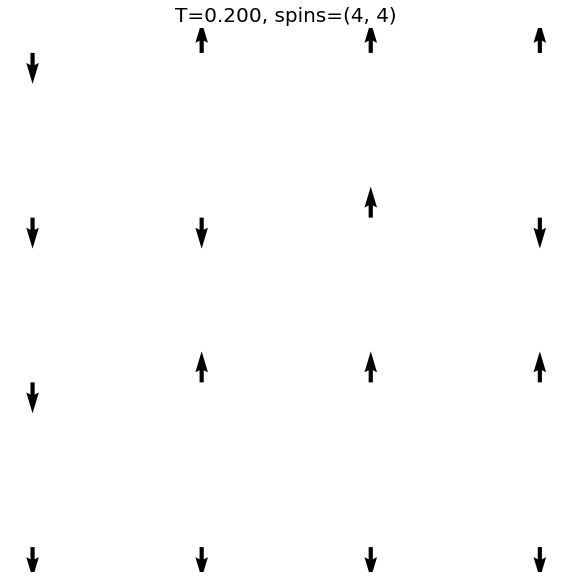

In [56]:
spin_viz(grid_1)

In [ ]:
num_steps = 1000
bond_dim = 20
grid_2, m_history_1, energy_history_1, _ = full_evv(grid_1, grid_2, num_steps, bond_dim)

In [ ]:
m_abs_mean = np.mean(np.abs(m_history_1))

In [68]:
print(f"abs mean of m is: {m_abs_mean:.3f}.")

abs mean of m is: 0.524.


-----
### 2D FI, T = 2.269, Size = 8

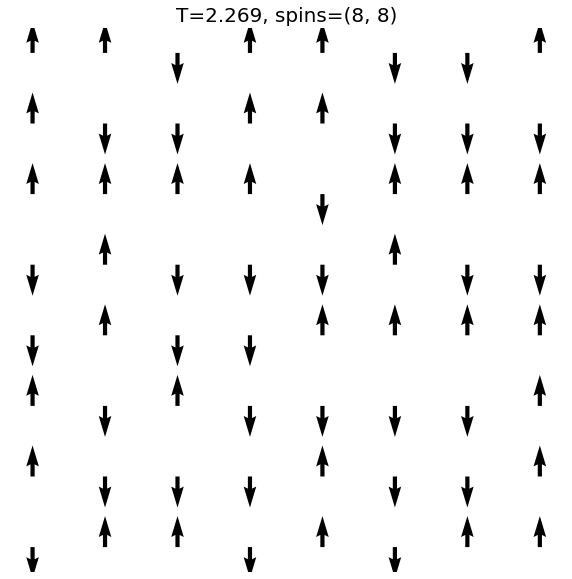

In [57]:
spin_viz(grid_1)

In [58]:
### Burning-in stage
time_start = time.time()
num_steps = 1000
bond_dim = 20
grid_1, m_history_1, energy_history_1, _ = full_evv(grid_1, grid_2, num_steps, bond_dim)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/1000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 552.1654577255249.


In [59]:
m_abs_mean = np.mean(np.abs(m_history_1))

In [60]:
print(f"abs mean of m is: {m_abs_mean:.3f}.")

abs mean of m is: 0.453.


-----------------
### 2D EA, T = 0.2, Size = 4

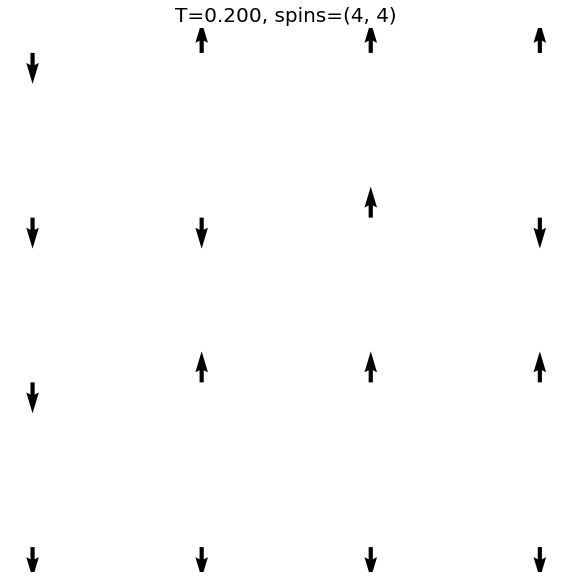

In [57]:
spin_viz(grid_1)

In [59]:
### Burning-in stage
time_start = time.time()
num_steps = 500
bond_dim = 2
grid_2, m_history_1, energy_history_1, _ = full_evv(grid_1, grid_2, num_steps, bond_dim)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/500 [00:00<?, ?it/s]

Time used for 1E5 steps is: 67.24779486656189.


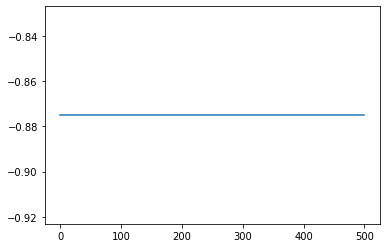

In [60]:
plt.plot(energy_history_1)

In [61]:
m_mean = np.mean(m_history_1)

In [62]:
print(f"mean of m is: {m_mean:.3f}.")

mean of m is: -0.011.


---------------------------------
### 2D EA, T = 0.2, Size = 8 

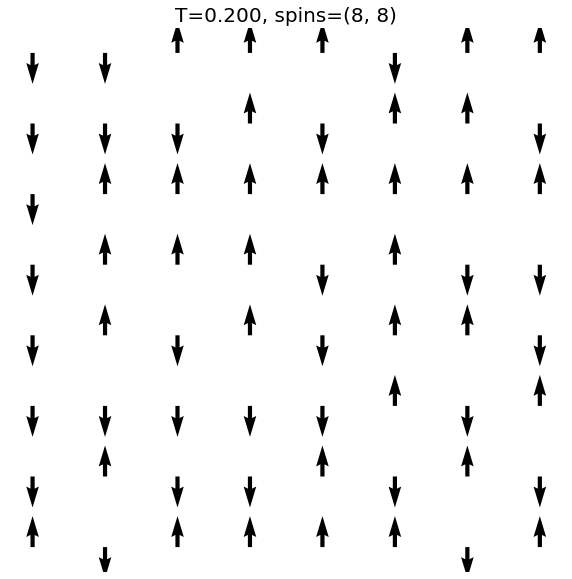

In [49]:
spin_viz(grid_1)

In [54]:
### Burning-in stage
time_start = time.time()
num_steps = 1000
bond_dim = 2
grid_2, m_history_1, energy_history_1, _ = full_evv(grid_1, grid_2, num_steps, bond_dim)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/1000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 566.9461467266083.


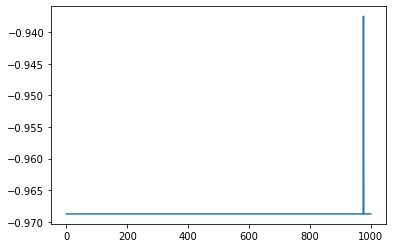

In [55]:
plt.plot(energy_history_1)

In [56]:
m_mean = np.mean(m_history_1)

In [57]:
print(f"mean of m is: {m_mean:.3f}.")

mean of m is: 0.014.


-------------------------------

In [73]:
### Burning-in stage
time_start = time.time()
num_steps = 1000
bond_dim = 20
grid_1_list = [grid_1_new, grid_1]
grid_2_list = [grid_2_new, grid_2]
grid_1, grid_2, m_hist_1, m_hist_2, e_hist_1, e_hist_2, _, _, q_list = full_evv_q(grid_1_list, grid_2_list, num_steps, bond_dim)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/1000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 245.695570230484.


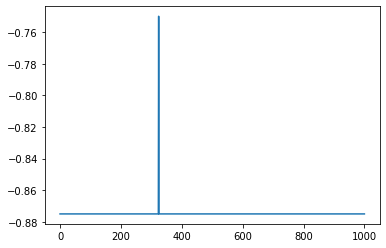

In [74]:
plt.plot(e_hist_1)

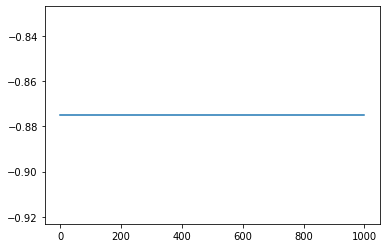

In [75]:
plt.plot(e_hist_2)

In [76]:
m_mean = np.mean(m_hist_1+m_hist_2)

In [77]:
print(f"mean of m is: {m_mean:.3f}.")

mean of m is: -0.003.


<AxesSubplot:ylabel='Count'>

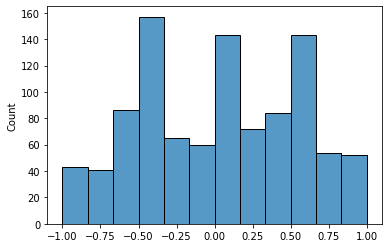

In [78]:
sns.histplot(q_list)